In [ ]:
# #Mounting my Google Drive to get access to the data files
from google.colab import drive
drive.mount('/content/gdrive/')

# This creates a symbolic link
!ln -s /content/gdrive/MyDrive /mydrive
!ls /mydrive

#Unzipping the dataset to the current directory which is /content/
!mkdir dataset
%cd dataset
!unzip -q '/mydrive/archive.zip'
%cd ..

 archive.zip		     'Cancer Detection Single Image.ipynb'
 CancerClassification.ipynb
mkdir: cannot create directory ‘dataset’: File exists
/content/dataset
/content


#Libraries Import

In [ ]:
#Data loading and directories handling
from glob import glob
from os import listdir

#Data Preprocessing
import numpy as np
import pandas as pd
from skimage.io import imread

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Deep Learning Model Designing Libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, img_to_array

#Performance Metrics
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

#Dataset Loading

In [ ]:
#Path to the dataset
base_path = "dataset/IDC_regular_ps50_idx5/"

#Files inside the dataset directory
folder = listdir(base_path)

#The folder contains subfolders with ids of the patients
print("Total number of patients: ", len(folder))

total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

print("Total number of patches pictures: ", total_images)

#Storing the paths to each file in pandas dataframe alongside the target label
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1

Total number of patients:  279
Total number of patches pictures:  277524


#Elementary Data Analysis (EDA)

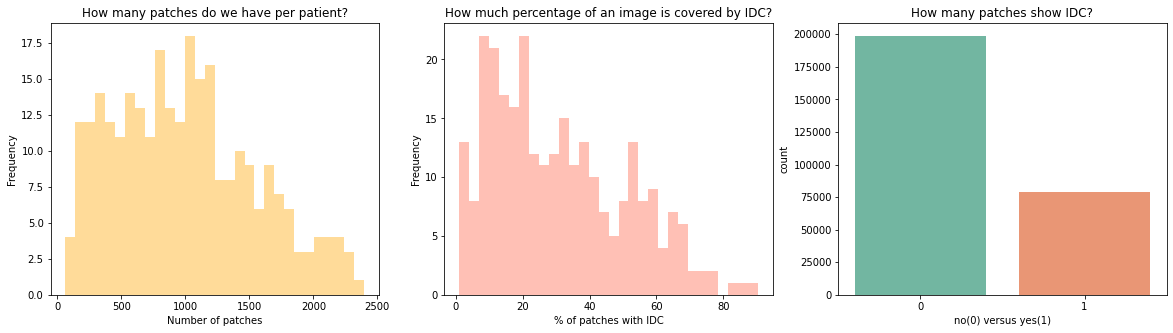

In [ ]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

#Plotting patches per patient
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");

#Number of positive vs negative cases
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

###Cancerous Tissues Visualization

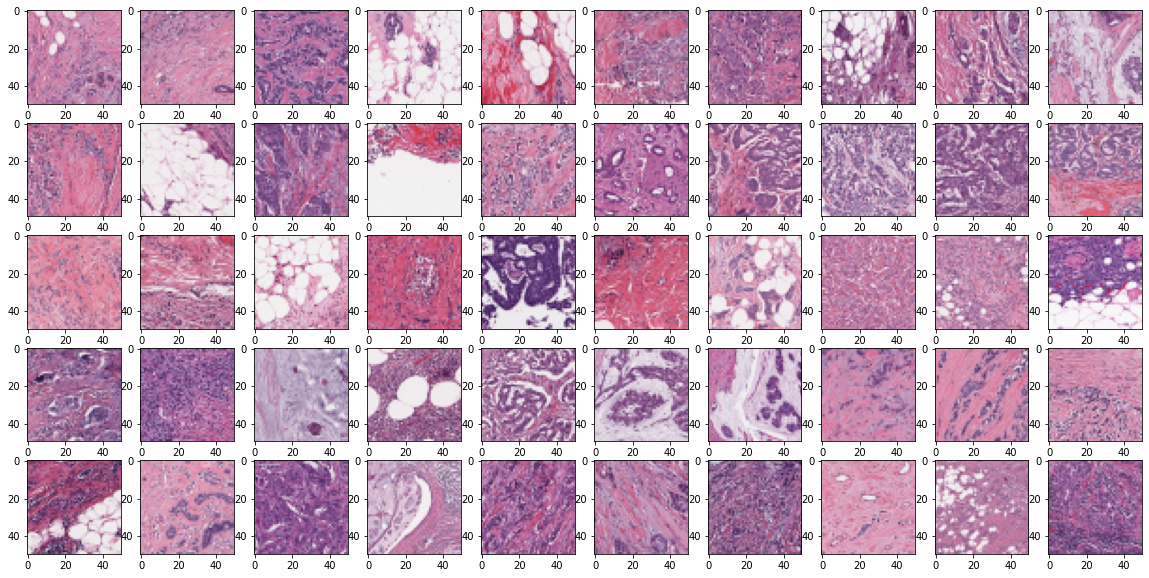

In [ ]:
data.target = data.target.astype(np.int)

#Storing the positive cases
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)

#Visualizing the positve cases
fig, ax = plt.subplots(5,10,figsize=(20,10))

#For loop over the images
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

###Non-Cancerous Tissues

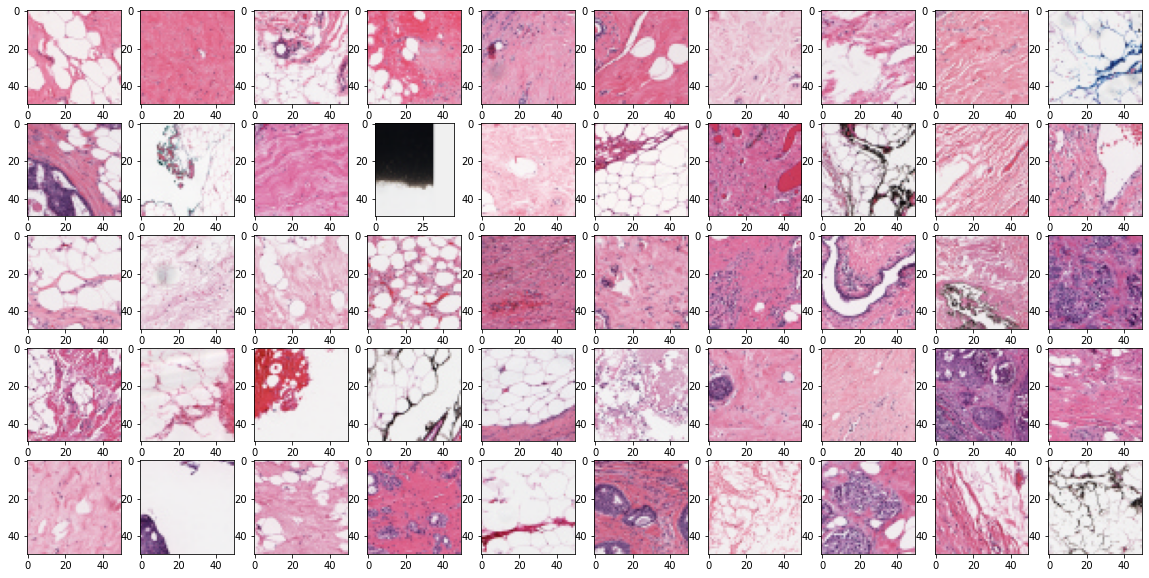

In [ ]:
#Fetching negative cases
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

#Create empty figure
fig, ax = plt.subplots(5,10,figsize=(20,10))

#For loop over the images to plot
for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

#Data Preprocessing

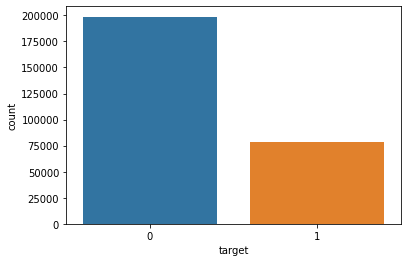

In [ ]:
#Lets plot how many positive and negative cases are in the dataset
sns.countplot(data['target'])

As can be seen from the above plot that positive cases are significantly lower than the negative cases. This creates a class imbalance. This would result in the biasness of the model towards the negative cases. In order to avoid that, we would balance the class imbalance. Notice that it would reduce our dataset for training.

###Balancing Class Imbalance

In [ ]:
data.head()

In [ ]:
#Balancing the class imbalance and normalizing the images
def load_balanced_data(files, size, start_index):
    half_size = int(size/2)
    count=0
    res = []
    y = []
    for file in files[start_index:]:
        if (count!=half_size):
            if file[-5] == '1' and file.endswith(".png"):
                img = load_img(file, target_size = (50,50))  #Resize image
                pixels = img_to_array(img)      #Convert image to numpy array 
                pixels /= 255                   #Normalizing the image
                res.append(pixels)              #Appending to list
                y.append(1)                     #Append the label
                count += 1                      #Increase count
                
    for file in files[start_index:]:
        if(count!=0):
            if(file[-5] == '0'):
                img = load_img(file, target_size = (50,50))
                pixels = img_to_array(img)
                pixels /= 255
                res.append(pixels)
                y.append(0)
                count -= 1
    return np.stack(res), np.array(y)  #Return the images and the labels

###Training Set

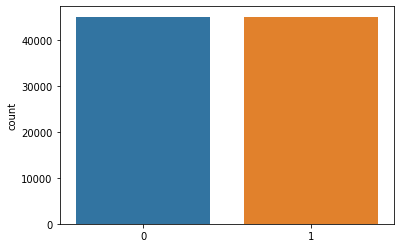

In [ ]:
#Create the training set
X_train, y_train = load_balanced_data(data['path'].tolist(), 90000,0)

#Lets see if the dataset is balanced now
sns.countplot(y_train);

###Test Set

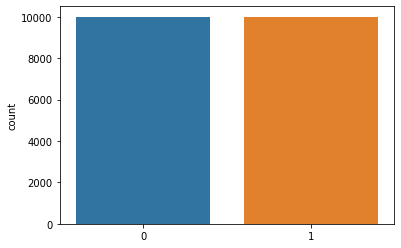

In [ ]:
#Creating the test set
x_test, y_test = load_balanced_data(data['path'].tolist(), 20000, 100000)

#Looking at the positive and negative class distribution
sns.countplot(y_test)

#Model Architecture Designing

In [ ]:
#Creation And Architecture of Concolutional Neural Network
def def_model(inp_shape = (50,50,3)):
    inp = Input(inp_shape)   #Shape of the images

    #Designing Model Layers
    #First Convolutional Layer with 32 filters of size 3 by 3 followed by Maxpooling
    m = Conv2D(32, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(inp)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)
    
    #Convolutional layer with 64 filters followed by maxpooling and batch normalization
    m = Conv2D(64, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)

    #Convolutional layer with 128 filters
    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    m = BatchNormalization()(m)

    m = Conv2D(128, (3,3), kernel_initializer='he_uniform', padding="same", activation='relu')(m)
    m = MaxPooling2D(2)(m)
    
    #Fully Connected layer with 128 neurons
    m = Flatten()(m)
    m = Dense(128, activation = "relu")(m)
    out = Dense(1, activation = "sigmoid")(m)
    
    #Creating the model
    model = Model(inp, out)

    #Model Compilation with Stochastic Gradient Descent Optimizer and binary cross entropy loss
    model.compile(optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9), loss="binary_crossentropy", metrics = ['acc'])
    return model

#Create the model
model = def_model()

#Uncomment to print the model details
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 25, 25, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0     

###Model Training

In [ ]:
#Model Hyperparameters
batches = 64
epochs  = 15

#Model Training
history = model.fit(X_train, y_train, validation_data=(x_test, y_test), epochs = epochs, batch_size=batches)

Epoch 1/15
1407/1407 [==============================] - 47s 26ms/step - loss: 0.4108 - acc: 0.8199 - val_loss: 0.3201 - val_acc: 0.8709
Epoch 2/15
1407/1407 [==============================] - 35s 25ms/step - loss: 0.3609 - acc: 0.8447 - val_loss: 0.3214 - val_acc: 0.8677
Epoch 3/15
1407/1407 [==============================] - 35s 25ms/step - loss: 0.3381 - acc: 0.8569 - val_loss: 0.4156 - val_acc: 0.8403
Epoch 4/15
1407/1407 [==============================] - 35s 25ms/step - loss: 0.3223 - acc: 0.8633 - val_loss: 0.3109 - val_acc: 0.8724
Epoch 5/15
1407/1407 [==============================] - 35s 25ms/step - loss: 0.3074 - acc: 0.8703 - val_loss: 0.3324 - val_acc: 0.8673
Epoch 6/15
1407/1407 [==============================] - 35s 25ms/step - loss: 0.2931 - acc: 0.8783 - val_loss: 0.2796 - val_acc: 0.8893
Epoch 7/15
1407/1407 [==============================] - 35s 25ms/step - loss: 0.2790 - acc: 0.8834 - val_loss: 0.3213 - val_acc: 0.8785
Epoch 8/15
1407/1407 [==========================

###Model Accuracy and Loss Plots

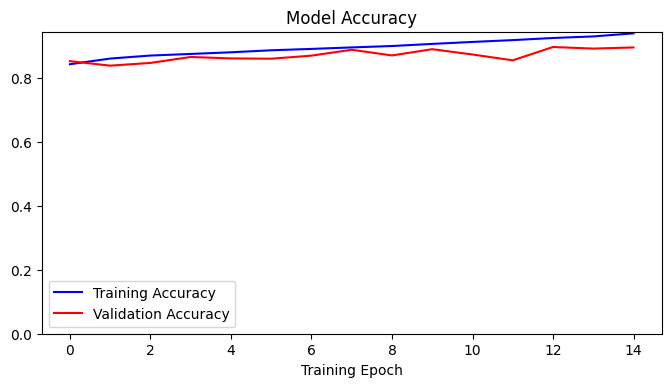

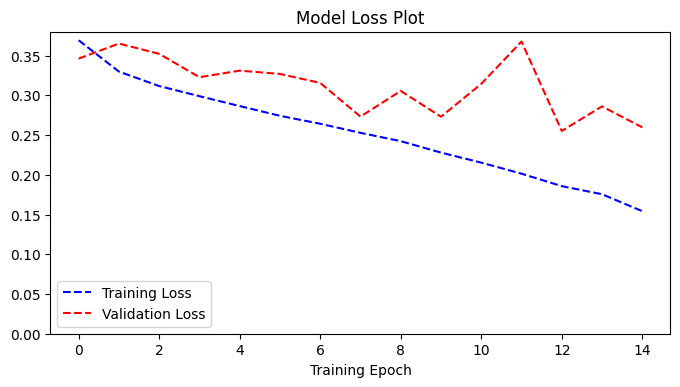

In [ ]:
#Plotting model accuracy
plt.figure(figsize=(8, 4), dpi=100)   #Empty Figure with size
#Fetching Training and Validation Accuracy
plt.plot(history.history['acc'], 'b', label='Training Accuracy') 
plt.plot(history.history['val_acc'], 'r', label='Validation Accuracy')
#Title and axis labeling
plt.title('Model Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#Model Loss Plotting
plt.figure(figsize=(8, 4), dpi=100)
plt.plot(history.history['loss'], 'b--', label='Training Loss')
plt.plot(history.history['val_loss'], 'r--', label='Validation Loss')
plt.title('Model Loss Plot')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

#Model Testing and Evaluation

In [ ]:
#This function is used for plotting the confusion matrix of the classified cases
LABELS = ['Non-IDC','IDC']
def plot_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4),dpi=100)
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('Ground Truth')
    plt.xlabel('Predictions')
    plt.show()

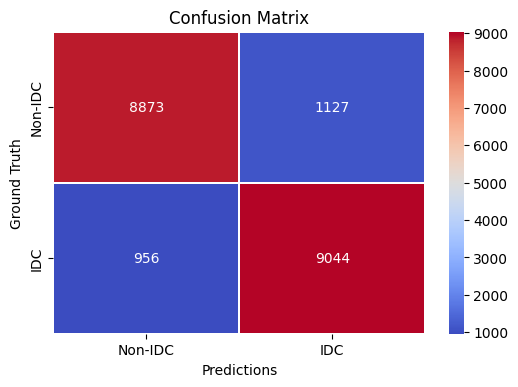

              precision    recall  f1-score   support

           0       0.90      0.89      0.89     10000
           1       0.89      0.90      0.90     10000

    accuracy                           0.90     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.90      0.90      0.90     20000



In [ ]:
#Predictions using the trained model
#Notice the probability threshold is kept at 0.5
model_predictions = model.predict(x_test) > 0.5

#Plotting Confusion matrix
plot_confusion_matrix(y_test, model_predictions)

#Classification Report of the model
print(classification_report(y_test, model_predictions))

#Save Trained Model

In [ ]:
#Save the trained model to .h5 keras format
model.save('best_model.h5')